# Learn the basics
My study notes and extracts while going through *PyTorch: Learn the Basics* [tutorial](https://docs.pytorch.org/tutorials/beginner/basics/intro.html).

## Tensors
- can share the same memory with Numpy arrays;
- optimized for automaitic differentation;
- a multi-dimensional array  with rank >= (0 - scalars, 1 - vectors, 2 - matrices). Don't confuse this with *matrix rank* in linear algebra.

In [40]:
import torch
import numpy as np

In [41]:
data = np.array([[1, 2],[3, 4]])
x_data = torch.tensor(data)
x_ones = torch.ones_like(x_data)
x_rand = torch.rand_like(x_data, dtype=torch.float)

print(f"Data Tensor: \n{x_data} \n")
print(f"Ones Tensor: \n{x_ones} \n")
print(f"Random Tensor: \n{x_rand} \n")

Data Tensor: 
tensor([[1, 2],
        [3, 4]]) 

Ones Tensor: 
tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
tensor([[0.1704, 0.2858],
        [0.5805, 0.2223]]) 



By default, tensors are allocated on CPU. If desired, they can be moved to the available accelerator using `.to` method.

In [42]:
tensor = torch.zeros((2, 4))
print(tensor.shape)
print(tensor.device)

if torch.accelerator.is_available():
    print("Accelerator is available")
    tensor = tensor.to(torch.accelerator.current_accelerator())
else:
    print("Accelerator is not available")

torch.Size([2, 4])
cpu
Accelerator is not available


All usual operators, like indexing and slicing, are available.

In [43]:
# slicing and indexing
tensor = torch.ones(3, 3, 3)
tensor[1, 1, :] = 0 # set the middle row of the middle matrix to zeros
print(tensor[1, :, :])

# concatenate tensors or stack
tensor = torch.ones((2, 3))
tensor_concat = torch.cat([tensor, tensor], dim = 0)
tensor_stack = torch.stack([tensor, tensor], dim = 0)
print(f"Concatenated tensors shape: {tensor_concat.shape}")
print(f"Stacked tensors shape: {tensor_stack.shape}")

tensor([[1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.]])
Concatenated tensors shape: torch.Size([4, 3])
Stacked tensors shape: torch.Size([2, 2, 3])


In the same way as for Numpy, we use `*` for element-wise products of tensors and `@` for the matrix-like multiplication.

In [44]:
matrix_multiplication = tensor @ tensor.T  # matrix multiplication
element_wise_multiplication = tensor * tensor   # element-wise multiplication
print(f"Matrix multiplication shape: {matrix_multiplication.shape}")
print(f"Element-wise multiplication shape: {element_wise_multiplication.shape}")

Matrix multiplication shape: torch.Size([2, 2])
Element-wise multiplication shape: torch.Size([2, 3])


To calculate some aggregated statistics we can use the available methods and use `.item` to convert it to a numerical value. Underscore `_` means that the operand is in-place.

In [45]:
sum = tensor.sum()
print(f"Sum: {type(sum)}, Sum item: {type(sum.item())}")

scalar_tensor = torch.ones(1)
scalar_tensor.add_(10)
print(f"Scalar tensor item: {scalar_tensor.item()}")

Sum: <class 'torch.Tensor'>, Sum item: <class 'float'>
Scalar tensor item: 11.0


If `.numpy()` method is used on a tensor, it returns a reference, so changing one will change the other.

In [46]:
scalar_tensor_np = scalar_tensor.numpy()
print(f"Scalar tensor numpy item: {scalar_tensor_np.item()}")
scalar_tensor_np[:] = 0
print(f"After in-place addition, scalar tensor item: {scalar_tensor.item()}")
print(f"After in-place addition, scalar tensor numpy item: {scalar_tensor_np.item()}")

Scalar tensor numpy item: 11.0
After in-place addition, scalar tensor item: 0.0
After in-place addition, scalar tensor numpy item: 0.0


## Datasets & dataloaders
We ideally want our data loading code to be decoupled from model training code. For that PyTorch provides two interfaces:
- `torch.utils.data.Dataset` - stores samples and their corresponding labels. Has to define three core methods: `__init__`, `__len__` and `__get_item__`.
- `torch.utils.data.DataLoader` - wraps iterable around the `Dataset`. Usually we want that to pass samples in "minibatches" and shuffle data at every epoch. This class abstracts this complexity.

To prototype models several datasets are available from PyTorch.

In [47]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Feature batch shape: torch.Size([15, 1, 28, 28])
Label batch shape: torch.Size([15])


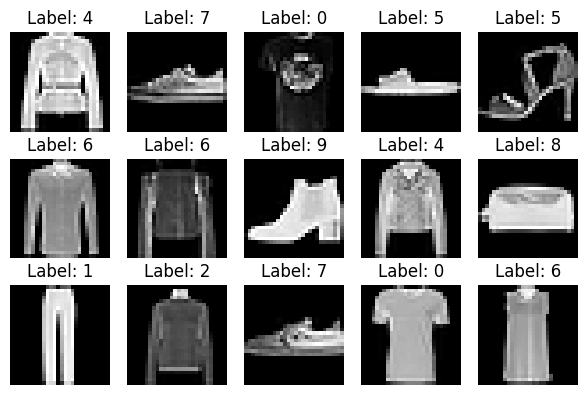

In [48]:
from torch.utils.data import DataLoader

subplots_grid = (3, 5)
n_elements_in_batch = subplots_grid[0] * subplots_grid[1]

train_dataloader = DataLoader(training_data, batch_size=n_elements_in_batch, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Label batch shape: {train_labels.size()}")

fig, axes = plt.subplots(*subplots_grid, figsize=(6, 4))
for batch_idx in range(n_elements_in_batch):
    i, j = np.unravel_index(batch_idx, subplots_grid)
    axes[i, j].imshow(train_features[batch_idx].squeeze(), cmap="gray")
    axes[i, j].set_title(f"Label: {train_labels[batch_idx]}")
    axes[i, j].axis("off")
fig.tight_layout()
plt.show()

## Transforms
This allows to perform some manipulation of the data to make it suitable for training. `Dataset` has two parameters:
- `transform` to modify features, or input data.
- `target_transform` to modify labels.

The [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html) offers a variety of helpers out of box.

For example, to convert the labels of FashionMNIST dataset to one-hot encoded tensors, one could do the following:

In [49]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.nn.functional import one_hot

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: one_hot(torch.tensor(y), num_classes=10).float())
)

## Build the neural network
First step is to define the neural network architechture. This is done by subclassing `nn.Module` followed by definition and initialization of the neural network layers in `__init__`. Every `nn.Module` subclass implements the opertations on input in `forward` method.


In [50]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # converts 2D image to 1D vector
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Internally the model consists of:
- The flattening layer, that converts a grayscale image to a flattened vector, which length is 28*28=784.
- Fully-connected layers:
  - the first layer accepts 784 features and outputs 512. Internally, it stores a bias vector `b` of shape `[512]`, and the weight matrix `W` of shape `[512, 784]`. The output of the layer is computed as: `y = W @ x.T + b`, or `y = x @ W.T + b`.
  - the output of the first layer is passed through a non-linear activation function (`ReLU`). Non-linear activations allow the NN to capture complex dependencies between inputs and outputs.
  - the second layer is a hidden layer that accepts 512 input features and maps them to 512 output features: it stores a bias vector of shape `[512]` and the weight matrix `W` of shape `[512, 512]`.
  - the output of the second layer is passed through a non-linear activation function once again.
  - The final layer maps 512 input features to 10 raw, unnormalized scores. Its `W` matrix size is `[10, 512]` and bias vector size is 10.

To check manually computed weights and biases sizes we can iterate over parameters and print their sizes:

In [51]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0063,  0.0163, -0.0114,  ..., -0.0334, -0.0219,  0.0322],
        [ 0.0178, -0.0129,  0.0207,  ..., -0.0290, -0.0264,  0.0250]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0331, -0.0257], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0266,  0.0132,  0.0264,  ..., -0.0158,  0.0086, -0.0355],
        [ 0.0155, -0.0433, -0.0386,  ..., -0.0198,  0.0349, -0.0382]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([512]) | Values : tensor([-0.0146,  0.0129], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.4.weight | Size: torch.Size([10, 512]) | Values : tensor([[-0.0067,  0.0228,  0.0264,  ..., -0.0280,  0.0048,  0.0036],
        [-0.0194, -0.0232,  0.0125,  ...,  0.0013,  0.0114,  0.0278]],
       grad_fn=<SliceBackward0>)

Now, if we want to use the model, we feed in our data and get output. The model returns 2-dimensional tensor `[batch_size, num_classes]`:

In [52]:
X = torch.rand(1, 28, 28)
logits = model(X)
print(logits)

tensor([[ 0.0120,  0.0271, -0.0188,  0.0150, -0.0656,  0.0590,  0.1259, -0.0392,
         -0.0789,  0.0629]], grad_fn=<AddmmBackward0>)


Now, if we want convert our raw scores from the last linear layer into probabilities we can use softmax function:
$$
p = \frac{e^{z_i}}{\sum_j{e^{z_j}}}.
$$

In [53]:
logits_np = logits.detach().numpy()
exp = np.exp(logits_np - logits_np.max())
probs = exp / exp.sum(axis=1, keepdims=True)
print(probs)

# or simply use nn.Softmax, dimension parameter indicates which dimension softmax would be computed along
pred_probab = nn.Softmax(dim=1)(logits)
print(pred_probab)

y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

[[0.10002154 0.10154515 0.09699149 0.10033008 0.09255714 0.10484016
  0.11208949 0.09503733 0.09133658 0.10525102]]
tensor([[0.1000, 0.1015, 0.0970, 0.1003, 0.0926, 0.1048, 0.1121, 0.0950, 0.0913,
         0.1053]], grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([6])


## Automatic differentation with `torch.autograd`
The training of neural networks is performed using forward and back-propogation.
- On a forward pass the inputs are used to calculate the loss function.
- On a backward pass the model parameters (weights and biases) are adjusted according to the gradient of the loss function w.r.t. the given parameters.

To compute those gradients, PyTorch has a built-in differnetation engine `torch.autograd`.

Let's play around with the simplest one-layer NN. Input is `x`, weights are `w` and biases are `b`.

**Notes**:
- the loss is tied to the NN architechture, so it updates the network parameters in-place after different methods are called on it.
- gradients are only available for nodes, which have `required_grad` property set to `True`.
- we can only perform gradient calculations once on a graph. If several calls are desired, `retain_graph` flag should be set.

In [54]:
import torch

x = torch.randn(5)
y = torch.zeros(3)

w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = x @ w + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(f"Loss: {loss}")

# to compute gradients a call to loss.backward() is required
loss.backward()
print(f"Gradient w.r.t. weights: {w.grad}") 
print(f"Gradient w.r.t. bias: {b.grad}")

Loss: 2.2008888721466064
Gradient w.r.t. weights: tensor([[-0.2073, -0.1949, -0.0758],
        [ 0.1192,  0.1120,  0.0435],
        [ 0.0007,  0.0006,  0.0002],
        [ 0.0992,  0.0932,  0.0362],
        [ 0.2001,  0.1881,  0.0731]])
Gradient w.r.t. bias: tensor([0.3249, 0.3054, 0.1187])


If we have fully trained network and just want to do inference (forward pass), we usually don't need any gradients computation at all.
Switching off gradient functionality can be achieved by doing computations inside `torch.no_grad()` block:

In [55]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


### Directed Acyclic Graphs
During computations, autograd keeps all the data and operations in a directed acyclic graph (DAG), where:
- the input tensors are leaves;
- the output tensors are roots (we call `.backward` on it).

*Note*: for forward pass, the inputs are roots, but outputs are leaves.

On a forwards pass `autograd`:
- runs the operations and computes the resulting tensor;
- snapshots the recipe for how to do backward pass (records the graph and required intermediate values).

One a backward pass:
- computes the gradients from each `.grad_fn`;
- accumulates them in the respective tensor's `.grad` attribute;
- propagates gradients from loss to all the leaf tensors.

## Optimizing model parameters
Now let's train the model, validate and test it.
Training is performed iteratively:
- model makes a guess about the output given current weights, biases and inputs;
- then it calculates the loss;
- propagates this loss back using partial derivatives.

The training process can be tuned by setting hyperparameters. They impact the model training and convergence rate. The typical hyperparameters are:
- number of epoches: the number of times to iterate over the dataset;
- batch size: the number of data samples, propagated through the network before backpropagating;
- learning rate - how much to update model parameters at each epoch.

Hyperparameters tuning can drastically effect the results. To test multiple of them [**Ray Tune**](https://docs.pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) can be used. It includes the latest hyperparameter search algorithms and supports distributed training.

### Loss function
**Loss function** measures the degree of dissimilarity between the value, predicted by the network and the target value.
Loss function is the function we want to minimize. The common loss functions are:
- Mean Square Error for regression;
- Negative Log Likelihood for classification;
- Cross Entropy Loss, that combines `nn.LogSoftmax` and `nn.NLLLoss`.

### Optimizer
An optimizer's goal is to adjust model parameters to minimize the target loss function. There are various optimization algorithms. All the optimization logic is encapsulated in `optimizer` object.

#### Optimization loop
An epoch is one cycle of the optimization loop. Each epoch consits of two steps:
- the train loop - iterate over the training dataset and try to converge to optimal parameters;
- the validation loop - iterate over the test dataset to check if model performance is improving.

Inside the loop several things happen:
- `optimizer.zero_grad()` resets the gradients, because by default they add up;
- backpropagation of the prediction loss with a call to `loss.backward()`;
- once all gradients are calculated, the call to `optimizer.step()` adjusts the parameters by the gradients collected in the backward pass.

Now it's time to define train and test loops to train the model and evaluate its performance.
Let's compare two NN models: the first one is standard, that flattens an image and has three fully-connected layers. The second one uses embeddings and cosine classifiaer to calculate logits.

In [56]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size=64):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

import torch.nn.functional as F

class NeuralNetworkCosineHead(nn.Module):
    def __init__(self, scale=10.0):
        super().__init__()
        self.flatten = nn.Flatten()
        self.backbone = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
        )
        self.head = nn.Linear(512,10, bias=False)
        self.scale = scale

    def forward(self, x):
        x = self.flatten(x)

        f = F.normalize(self.backbone(x), dim=-1)
        W = F.normalize(self.head.weight, dim=-1)
        logits = f @ W.T * 10.0

        return logits

class NeuralNetworkWithEmbeddingsDotProductHead(nn.Module):
    def __init__(self, emb_dim=16, scale=10.0):
        super().__init__()
        self.flatten = nn.Flatten() # converts 2D image to 1D vector
        self.backbone = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU()
        )
        self.proj = nn.Linear(512, emb_dim)
        self.class_emb = nn.Embedding(10, emb_dim)
        self.scale = scale

    def forward(self, x):
        x = self.flatten(x)
        h = self.backbone(x)
        f = self.proj(h)

        W = self.class_emb.weight
        logits = f @ W.T * self.scale 

        return logits

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

model_classic = NeuralNetworkCosineHead()
model_with_embeddings = NeuralNetworkWithEmbeddingsDotProductHead()

for model in [model_classic, model_with_embeddings]:
    print(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

    epochs = 5
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)


NeuralNetworkCosineHead(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (head): Linear(in_features=512, out_features=10, bias=False)
)
Epoch 1
-------------------------------
loss: 2.310842  [   64/60000]
loss: 1.469005  [ 6464/60000]
loss: 0.909483  [12864/60000]
loss: 1.001691  [19264/60000]
loss: 0.758213  [25664/60000]
loss: 0.790737  [32064/60000]
loss: 0.749348  [38464/60000]
loss: 0.673423  [44864/60000]
loss: 0.685838  [51264/60000]
loss: 0.668831  [57664/60000]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.625605 

Epoch 2
-------------------------------
loss: 0.531847  [   64/60000]
loss: 0.651578  [ 6464/60000]
loss: 0.377852  [12864/60000]
loss: 0.681120  [19264/60000]
loss: 0.555134  [25664/60000]
loss: 0.603500  [32064/60000]
loss: 0.583237  [38464/60000]
loss: 0.578776  [44864/60000]
loss: 

## Save and load the model
PyTorch models can be saved and loaded. The learned parameters are stored in an internal state dicitonary, called `state_dict` and can be saved using `torch.save` function.

In [57]:
torch.save(model_with_embeddings.state_dict(), "model_with_embeddings.pth")

To load model weights, the instance of the same model needs to be created and then populated with `load_state_dict()` method.

In [58]:
model_copy = NeuralNetworkWithEmbeddingsDotProductHead()
model_copy.load_state_dict(torch.load("model_with_embeddings.pth", weights_only=False))
model_copy.eval()

NeuralNetworkWithEmbeddingsDotProductHead(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (proj): Linear(in_features=512, out_features=16, bias=True)
  (class_emb): Embedding(10, 16)
)

If we want to save the whole model, with its structure, we need to call `save` on the object instance.